In [3]:
import os, sys

# Notebook lives in <project>/notebooks/, so add its parent (the project root)
proj_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, proj_root)

print("Project root added to sys.path:", proj_root)

Project root added to sys.path: /Users/varunjhaveri/Desktop/Spring 25/MATH 590/loss-landscape


In [4]:
import torch.optim as optim

from models.shallow_relu import ShallowReLU
from experiments.shallow_trainer import ShallowReLUTrainer
from experiments.loss_surface_visualizer import LossSurfaceVisualizer
from analysis.gradient_analysis import GradientAnalyzer
from data.synthetic_generator import SyntheticDatasetBuilder
from experiments.activation_pattern_visualizer import ActivationPatternVisualizer
from experiments.critical_point_classifier import CriticalPointClassifier
from experiments.gradient_trajectory_analyzer import GradientTrajectoryAnalyzer
from experiments.weight_norm_monitor import WeightNormMonitor

In [5]:
# blobs, circles, or moons
builder = SyntheticDatasetBuilder(dataset_type="moons",
                                  n_samples=300,
                                  noise=0.1,
                                  test_size=0.2,
                                  random_state=42)
X_train, X_test, y_train, y_test = builder.generate()

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape, y_test.shape)


Train shapes: torch.Size([240, 2]) torch.Size([240, 1])
Test  shapes: torch.Size([60, 2]) torch.Size([60, 1])


Epoch  10: Loss = 0.7056
Epoch  20: Loss = 0.7053
Epoch  30: Loss = 0.7050
Epoch  40: Loss = 0.7047
Epoch  50: Loss = 0.7044
Epoch  60: Loss = 0.7041
Epoch  70: Loss = 0.7038
Epoch  80: Loss = 0.7035
Epoch  90: Loss = 0.7032
Epoch 100: Loss = 0.7029
Epoch 110: Loss = 0.7026
Epoch 120: Loss = 0.7023
Epoch 130: Loss = 0.7020
Epoch 140: Loss = 0.7018
Epoch 150: Loss = 0.7015
Epoch 160: Loss = 0.7012
Epoch 170: Loss = 0.7009
Epoch 180: Loss = 0.7006
Epoch 190: Loss = 0.7003
Epoch 200: Loss = 0.7000
Epoch 210: Loss = 0.6998
Epoch 220: Loss = 0.6995
Epoch 230: Loss = 0.6992
Epoch 240: Loss = 0.6989
Epoch 250: Loss = 0.6986
Epoch 260: Loss = 0.6984
Epoch 270: Loss = 0.6981
Epoch 280: Loss = 0.6978
Epoch 290: Loss = 0.6975
Epoch 300: Loss = 0.6972
Epoch 310: Loss = 0.6970
Epoch 320: Loss = 0.6967
Epoch 330: Loss = 0.6964
Epoch 340: Loss = 0.6961
Epoch 350: Loss = 0.6959
Epoch 360: Loss = 0.6956
Epoch 370: Loss = 0.6953
Epoch 380: Loss = 0.6950
Epoch 390: Loss = 0.6948
Epoch 400: Loss = 0.6945


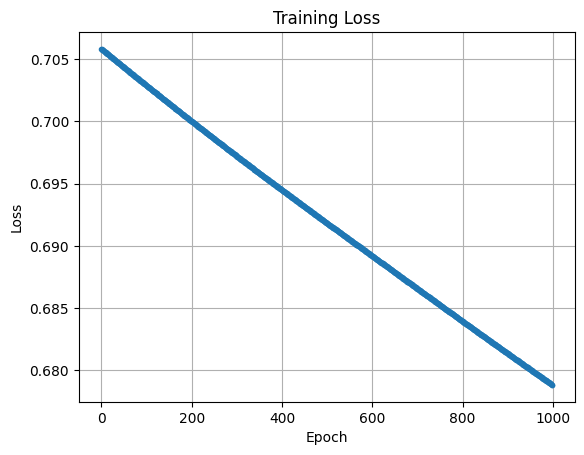

Test Accuracy: 56.67%


0.5666666626930237

In [15]:
trainer = ShallowReLUTrainer(input_dim=2,   
                             hidden_dim=5,  
                             lr=0.001,
                             num_epochs=1000)

# override with the generated data
trainer.X_train, trainer.X_test = X_train, X_test
trainer.y_train, trainer.y_test = y_train, y_test

trainer.train()
trainer.plot_loss_curve()
trainer.evaluate()

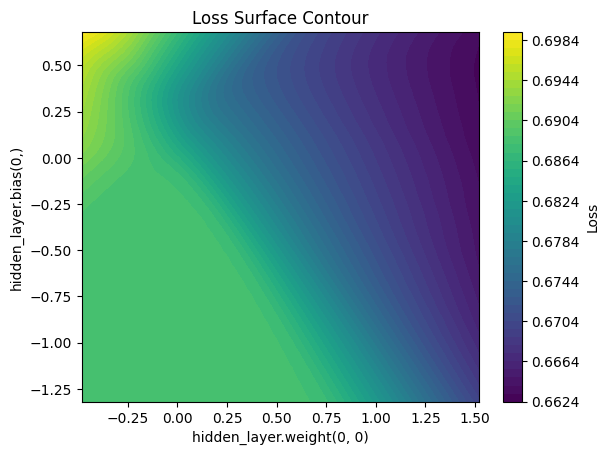

In [16]:
vis = LossSurfaceVisualizer(
    trainer.model,
    trainer.criterion,
    trainer.X_train,
    trainer.y_train
)

# Sweep around the first hidden weight & bias:
vis.sweep_2d(
    param1=('hidden_layer.weight', (0, 0)),
    param2=('hidden_layer.bias',   (0,)),
    resolution=50,
    span=1.0
)
vis.plot_surface()


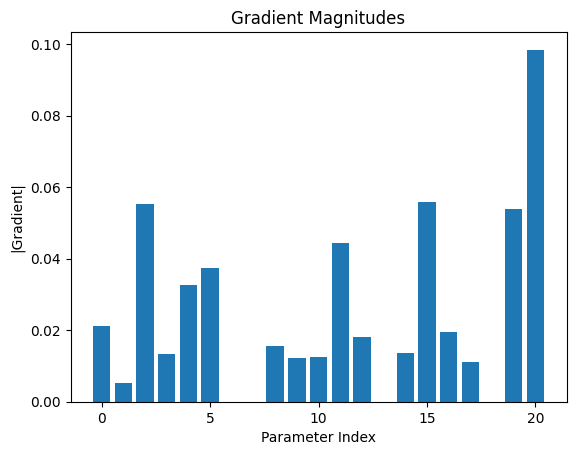

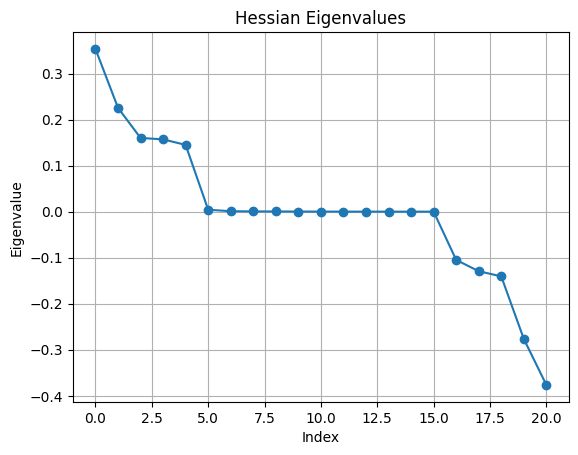

In [17]:
analyzer = GradientAnalyzer(
    trainer.model,
    trainer.criterion,
    trainer.X_train,
    trainer.y_train
)

# Gradient magnitudes
analyzer.plot_gradient_norm()

# Hessian spectrum 
H = analyzer.compute_hessian()
analyzer.plot_hessian_spectrum(H)

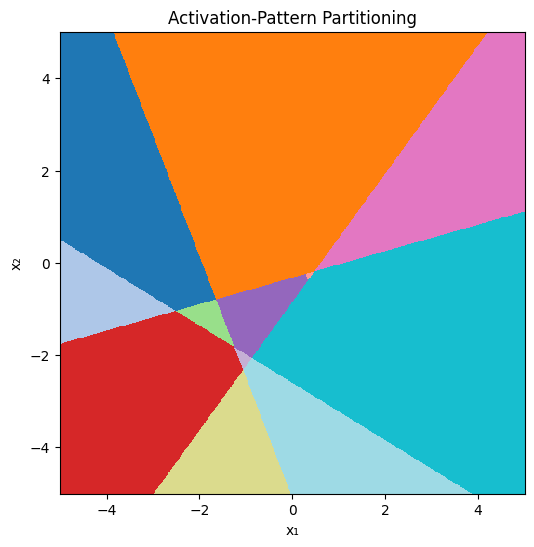

In [18]:
# Instantiating the visualizer
partitioner = ActivationPatternVisualizer(
    trainer.model,
    xlim=(-5, 5),       # should cover data range
    ylim=(-5, 5),
    resolution=500      # finer grid for the smoother regions
)

# Computing activation patterns over the grid
partitioner.compute_patterns()
partitioner.plot_partition()


In [19]:
# Critical Point Classification

cpc = CriticalPointClassifier(
    trainer.model,
    trainer.criterion,
    trainer.X_train,
    trainer.y_train
)
label, eigs = cpc.classify_current(
    grad_tol=1e-2,  
    eig_tol=1e-4    
)
print("This point is classified as:", label)


This point is classified as: Not critical (‖∇L‖ > tol)


Epoch  10: Loss=0.6556, ‖∇L‖=0.1618
Epoch  20: Loss=0.6287, ‖∇L‖=0.1646
Epoch  30: Loss=0.6016, ‖∇L‖=0.1652
Epoch  40: Loss=0.5744, ‖∇L‖=0.1639
Epoch  50: Loss=0.5488, ‖∇L‖=0.1574
Epoch  60: Loss=0.5252, ‖∇L‖=0.1498
Epoch  70: Loss=0.5037, ‖∇L‖=0.1418
Epoch  80: Loss=0.4848, ‖∇L‖=0.1330
Epoch  90: Loss=0.4681, ‖∇L‖=0.1253
Epoch 100: Loss=0.4531, ‖∇L‖=0.1192


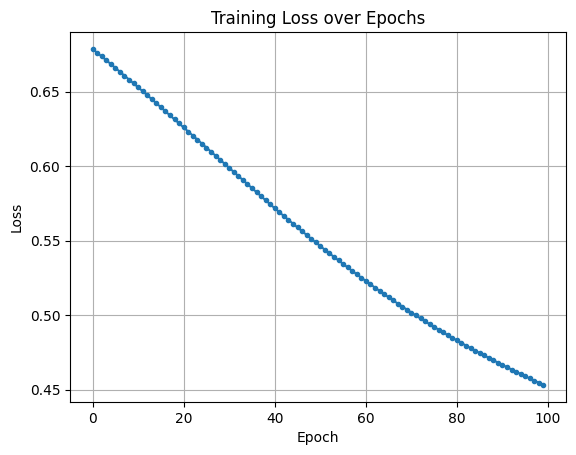

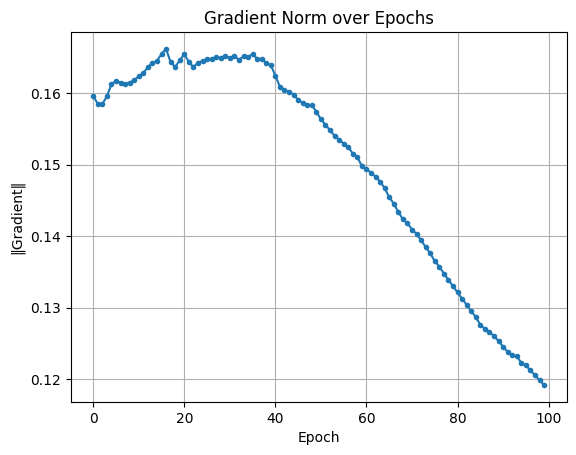

In [20]:
# instantiate optimizer
optimizer = optim.SGD(trainer.model.parameters(), lr=0.1)

# run tracking
gt_analyzer = GradientTrajectoryAnalyzer(
    trainer.model,
    trainer.criterion,
    optimizer,
    trainer.X_train,
    trainer.y_train,
    num_epochs=100
)
loss_hist, grad_norms = gt_analyzer.track()

# plots
gt_analyzer.plot_loss()
gt_analyzer.plot_grad_norm()


Epoch  10: Loss = 0.4752
Epoch  20: Loss = 0.4242
Epoch  30: Loss = 0.3828
Epoch  40: Loss = 0.3482
Epoch  50: Loss = 0.3188
Epoch  60: Loss = 0.2933
Epoch  70: Loss = 0.2711
Epoch  80: Loss = 0.2515
Epoch  90: Loss = 0.2341
Epoch 100: Loss = 0.2186
Test Accuracy: 100.00%
Epoch  10: Loss = 0.6954
Epoch  20: Loss = 0.6948
Epoch  30: Loss = 0.6944
Epoch  40: Loss = 0.6941
Epoch  50: Loss = 0.6938
Epoch  60: Loss = 0.6936
Epoch  70: Loss = 0.6935
Epoch  80: Loss = 0.6933
Epoch  90: Loss = 0.6932
Epoch 100: Loss = 0.6932
Test Accuracy: 45.00%
Epoch  10: Loss = 0.2077
Epoch  20: Loss = 0.1053
Epoch  30: Loss = 0.0631
Epoch  40: Loss = 0.0429
Epoch  50: Loss = 0.0318
Epoch  60: Loss = 0.0249
Epoch  70: Loss = 0.0203
Epoch  80: Loss = 0.0170
Epoch  90: Loss = 0.0146
Epoch 100: Loss = 0.0127
Test Accuracy: 100.00%
Epoch  10: Loss = 0.4246
Epoch  20: Loss = 0.2262
Epoch  30: Loss = 0.1179
Epoch  40: Loss = 0.0703
Epoch  50: Loss = 0.0473
Epoch  60: Loss = 0.0346
Epoch  70: Loss = 0.0269
Epoch  

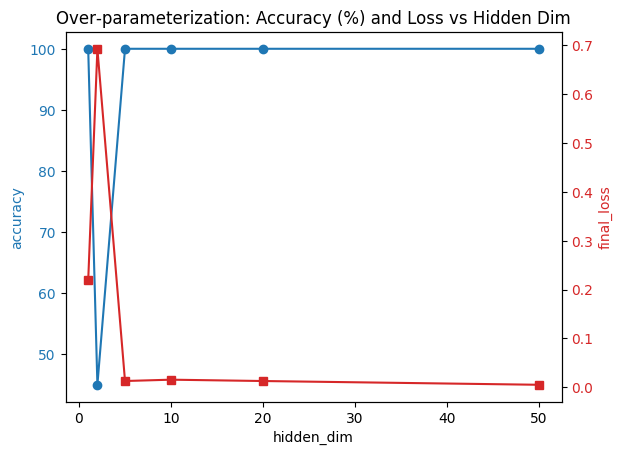

In [21]:
# Over‑parameterization Study
import matplotlib.pyplot as plt
from data.synthetic_generator import SyntheticDatasetBuilder
from experiments.overparam_experiment import OverparamExperiment

# 1) Prepare dataset builder
builder = SyntheticDatasetBuilder(dataset_type="blobs", n_samples=500, noise=0.1)

# 2) Define hidden dims to sweep
hidden_sizes = [1, 2, 5, 10, 20, 50]

# 3) Run the experiment
exp = OverparamExperiment(builder, hidden_dims=hidden_sizes, lr=0.05, num_epochs=100)
df = exp.run()
print(df)

# 4) Plot results
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('hidden_dim')
ax1.set_ylabel('accuracy', color=color)
ax1.plot(df.hidden_dim, df.accuracy * 100, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('final_loss', color=color)
ax2.plot(df.hidden_dim, df.final_loss, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Over‑parameterization: Accuracy (%) and Loss vs Hidden Dim")
plt.show()


Epoch  10: Loss=0.3925, WeightNorm=2.8431
Epoch  20: Loss=0.3844, WeightNorm=2.9107
Epoch  30: Loss=0.3768, WeightNorm=2.9766
Epoch  40: Loss=0.3698, WeightNorm=3.0410
Epoch  50: Loss=0.3633, WeightNorm=3.1037
Epoch  60: Loss=0.3574, WeightNorm=3.1647
Epoch  70: Loss=0.3520, WeightNorm=3.2240
Epoch  80: Loss=0.3470, WeightNorm=3.2813
Epoch  90: Loss=0.3423, WeightNorm=3.3368
Epoch 100: Loss=0.3381, WeightNorm=3.3906


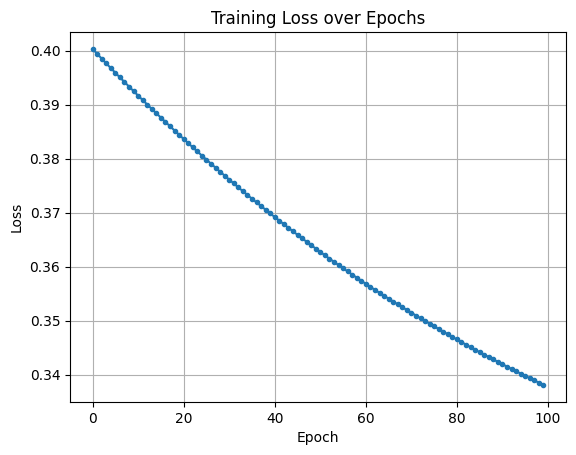

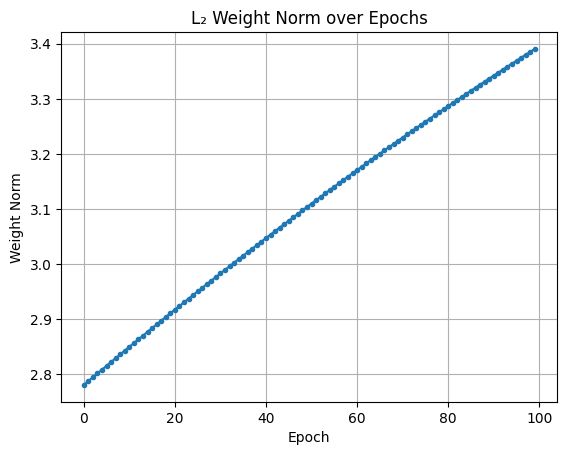

In [24]:
# Implicit Regularization via Weight Norm

# 1) set up optimizer
optimizer = optim.SGD(trainer.model.parameters(), lr=0.1)

# 2) track weight norms
wn_monitor = WeightNormMonitor(
    trainer.model,
    trainer.criterion,
    optimizer,
    trainer.X_train,
    trainer.y_train,
    num_epochs=100
)
loss_hist, wnorms = wn_monitor.track()

# 3) plot
wn_monitor.plot_loss()
wn_monitor.plot_weight_norm()
